In [ ]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
'''
Steps:
1. change latest_folder = "scenario_folder_scenario_76.json" to the scenario in logs/scenarios/ 
corresponds to your TEST DATA
2. change this too: results_df = pd.read_csv(os.path.join(scenario_folder_path, f"6ac-26-lilac_{len(seeds)}_seeds.csv"))
3. check if results_df is correct (same as output_file in run_inference.py)
4. run the script normally to obtain the comparison table as a csv file in logs/inference_metrics/
5. run this command if you want to see the output as txt file: python interpretation/qualitative-analysis/EO_final-results-examples-fixed.py > output.txt 2>&1
6. change the seeds to 101 if you want (takes longer but better results)
Uses GREEDY REACTIVE BASELINE from environment.py or GREEDY REACTIVE BASELINE from main-optimizer.py
'''
# Set up the environment
sns.set_theme(style="darkgrid")

# Set pandas display options to show all columns and values
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

seeds = []
for i in range(1, 6):
    seeds.append(i)

def time_to_minutes(timestr):
    # Handle '+1' suffix by removing it before parsing
    timestr = timestr.split('+')[0]  # Remove '+1' if present
    hh, mm = timestr.split(':')
    return int(hh) * 60 + int(mm)

def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flights = len(flights)
    total_flight_minutes_in_recovery = 0
    total_flight_minutes_total = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        total_flight_minutes_total += arr_minutes - dep_minutes
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack, total_flights, total_flight_minutes_total

def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob, total_aircraft

# Path to the scenarios folder
scenario_folder_path = "../../logs/scenarios/"
latest_folder = "scenario_folder_scenario_76.json" # Testing on 6ac-26-lilac, training on 6ac-65-yellow

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']

# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack, total_flights, total_flight_minutes_total = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob, total_aircraft = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "TotalFlights": total_flights,
        "TotalFlightMinutes": total_flight_minutes_total,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob,
        "TotalAircraft": total_aircraft
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)


# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 76
Data Folder: ../data/TRAINING/6ac-26-lilac/
                        Scenario  ScenarioSlack  TotalFlights  \
0   deterministic_Scenario_00001       0.322037            19   
1   deterministic_Scenario_00002       0.375714            23   
2   deterministic_Scenario_00003       0.301068            17   
3   deterministic_Scenario_00004       0.329798            24   
4   deterministic_Scenario_00005       0.331650            20   
5   deterministic_Scenario_00006       0.309829            17   
6   deterministic_Scenario_00007       0.388725            20   
7   deterministic_Scenario_00008       0.286380            19   
8      stochastic_Scenario_00009       0.365185            18   
9      stochastic_Scenario_00010       0.253704            18   
10     stochastic_Scenario_00011       0.295833            21   
11     stochastic_Scenario_00012       0.344781            19   
12     stochastic_Scenario_00013       0.285522            21   
13     stochastic_Scenario_000

<div class="alert alert-block alert-success">
</br>
</br>
</br>
<b>DONE: </b>MERGED DATASET
</br>
</br>
</br>
</br>
</div>

In [2]:
import os
import pandas as pd

scenario_folder_path = "../../logs/inference_metrics/"
# unpack results_df
# results_df = pd.read_csv(os.path.join(scenario_folder_path, f"6ac-26-lilac_{len(seeds)}_greedy_reactive.csv"))
results_df = pd.read_csv(os.path.join(scenario_folder_path, f"6ac-26-lilac_{len(seeds)}_trying.csv"))

# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

# Add scenario category based on prefix and difficulty level
merged_df["ScenarioCategory"] = merged_df["Scenario"].apply(
    lambda x: "Deterministic" if x.startswith("deterministic") else
             "Stochastic High" if x.startswith("stochastic_high") else
             "Stochastic Medium" if x.startswith("stochastic_medium") else
             "Stochastic Low" if x.startswith("stochastic_low") else
             "Mixed High" if x.startswith("mixed_high") else
             "Mixed Medium" if x.startswith("mixed_medium") else
             "Mixed Low" if x.startswith("mixed_low") else
             "Other"
)

# Sort models in desired order
model_order = ['proactive', 'myopic', 'reactive', 'greedy_reactive']
merged_df['Model_Type'] = merged_df['Model'].str.extract('(' + '|'.join(model_order) + ')')
merged_df = merged_df.sort_values('Model_Type')
merged_df["Model"] = merged_df["Model_Type"]
merged_df = merged_df.drop('Model_Type', axis=1)
merged_df_backup = merged_df.copy()


# Update model names in merged_df
merged_df['Model'] = merged_df['Model'].apply(lambda x: 
    'DQN Proactive-U' if x.startswith('proactive') else
    'DQN Proactive-N' if x.startswith('myopic') else 
    'DQN Reactive' if x.startswith('reactive') else
    'Greedy Reactive' if x.startswith('greedy_reactive') else
    x
)

print("Inference Results (After Merging):")
print(merged_df)

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")



# print all column names
print("==== Columns: ====")
print(merged_df.columns)

print("==== amount of rows: ====")
print(len(merged_df))

print("==== Models: ====")
print(merged_df["Model"].unique())

print('===== len(seeds) =====')
print(len(merged_df['Seed'].unique()))

print('===== len(scenarios) =====')
print(len(merged_df['Scenario'].unique()))


Inference Results (After Merging):
                         Scenario            Model  Seed  TotalReward  \
454          mixed_Scenario_00025  Greedy Reactive     5      14687.2   
346          mixed_Scenario_00022  Greedy Reactive     2       -107.6   
347          mixed_Scenario_00022  Greedy Reactive     3      19529.8   
348          mixed_Scenario_00022  Greedy Reactive     4       -107.6   
349          mixed_Scenario_00022  Greedy Reactive     5      19529.8   
..                            ...              ...   ...          ...   
676     stochastic_Scenario_00014     DQN Reactive     2     -10169.2   
675     stochastic_Scenario_00014     DQN Reactive     1     -10169.2   
360          mixed_Scenario_00023     DQN Reactive     1     -15331.8   
81   deterministic_Scenario_00003     DQN Reactive     2     -15271.6   
115  deterministic_Scenario_00004     DQN Reactive     1         -6.0   

     TotalDelays  TotalCancelledFlights  ScenarioTime  ScenarioSteps  \
454          0.0

<div class="alert alert-block alert-info">
<b>Check: </b>Comparison of Models Across All Scenarios
</div>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# First aggregate by Model and Seed, then calculate mean and std across seeds
comparison_table = (
    merged_df
    .groupby(['Model', 'Seed'])
    .agg(
        TotalReward=('TotalReward', 'mean'),
        ScenarioTime=('ScenarioTime', 'mean'), 
        ScenarioSteps=('ScenarioSteps', 'mean'),
        TotalDelays=('TotalDelays', 'mean'),
        TotalCancelledFlights=('TotalCancelledFlights', 'mean'),
        TotalTailSwaps=('TailSwaps', 'mean')
    )
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Std_Reward=('TotalReward', 'std'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Std_Runtime=('ScenarioTime', 'std'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Std_Steps=('ScenarioSteps', 'std'),
        Mean_Delays=('TotalDelays', 'mean'),
        Std_Delays=('TotalDelays', 'std'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Std_CancelledFlights=('TotalCancelledFlights', 'std'),
        Mean_TailSwaps=('TotalTailSwaps', 'mean'),
        Std_TailSwaps=('TotalTailSwaps', 'std')
    )
    .round(2)
)

# Sort the comparison table according to specified order
model_order = ['Greedy Reactive', 'DQN Reactive', 'DQN Proactive-N', 'DQN Proactive-U']
comparison_table = comparison_table.reindex(model_order)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                 Mean_Reward  Std_Reward  Mean_Runtime  Std_Runtime  \
Model                                                                 
Greedy Reactive     22873.35     1843.73          0.50         0.03   
DQN Reactive       -10841.14      604.14          0.04         0.00   
DQN Proactive-N     -4128.31     1627.10          0.05         0.01   
DQN Proactive-U     -8033.24      745.33          0.04         0.00   

                 Mean_Steps  Std_Steps  Mean_Delays  Std_Delays  \
Model                                                             
Greedy Reactive        6.92       0.14         9.60        5.29   
DQN Reactive           8.08       0.15         0.00        0.00   
DQN Proactive-N        7.82       0.17       125.55        9.69   
DQN Proactive-U        7.90       0.12        74.46        1.04   

                 Mean_CancelledFlights  Std_CancelledFlights  Mean_TailSwaps  \
Model                                          

In [5]:
"""
info on merged_df:

[280000 rows x 27 columns]
Inference results with scenario info saved to ../logs/scenarios/scenario_inference_metrics_4.csv
==== Columns: ====
Index(['Scenario', 'Model', 'Seed', 'TotalReward', 'TotalDelays',
       'TotalCancelledFlights', 'ScenarioTime', 'ScenarioSteps',
       'ScenarioResolvedConflicts', 'SolutionSlack', 'TailSwaps',
       'ActualDisruptedFlights', 'Reward_delay_penalty_total',
       'Reward_cancel_penalty', 'Reward_inaction_penalty',
       'Reward_proactive_bonus', 'Reward_time_penalty',
       'Reward_final_conflict_resolution_reward', 'ScenarioSlack',
       'TotalFlights', 'TotalFlightMinutes', 'FullyDisruptedCount',
       'UncertainCount', 'AvgAircraftProbability', 'AvgUncertaintyProbability',
       'TotalAircraft', 'ScenarioCategory'],
      dtype='object')
==== amount of rows: ====
280000
==== Models: ====
['Greedy Reactive' 'DQN Proactive-N' 'DQN Proactive-U' 'DQN Reactive']
===== len(seeds) =====
100
===== len(scenarios) =====
700
"""
# Get scenarios starting with "mixed" for DQN Proactive-U model
mixed_scenarios = merged_df[
    (merged_df['Model'] == 'DQN Proactive-U') & 
    (merged_df['Scenario'].str.startswith('mixed'))
]

# Group by scenario and calculate mean reward
scenario_means = mixed_scenarios.groupby('Scenario').agg({
    'TotalReward': 'mean',
    'ActualDisruptedFlights': 'mean'
}).reset_index()

# Get top 5 scenarios by average reward
top_5_scenarios = scenario_means.nlargest(5, 'TotalReward')
print("\nTop 5 'mixed' scenarios for DQN Proactive-U by average reward:")
print(top_5_scenarios)



Top 5 'mixed' scenarios for DQN Proactive-U by average reward:
               Scenario  TotalReward  ActualDisruptedFlights
5  mixed_Scenario_00026     17364.08                     3.2
3  mixed_Scenario_00024    -10126.40                     2.0
2  mixed_Scenario_00023    -15330.10                     3.0
0  mixed_Scenario_00021    -17929.81                     3.5
4  mixed_Scenario_00025    -19270.00                     3.8


DQN Proactive-U
DQN Proactive-N
DQN Reactive
Greedy Reactive


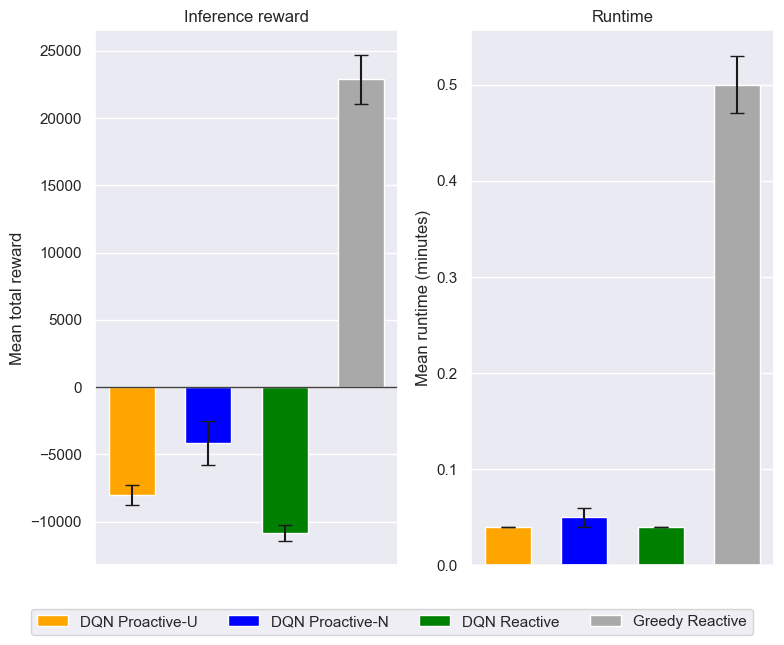

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}
# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.6

# Plot reward bars using model colors in specified order
for i, model in enumerate(sorted_models):
    print(model)
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax1.bar(i, comparison_table.loc[model, 'Mean_Reward'], width,
            yerr=comparison_table.loc[model, 'Std_Reward'],
            capsize=5, label=label, color=color)

ax1.set_ylabel('Mean total reward')
ax1.set_title('Inference reward')
ax1.set_xticks([])
ax1.axhline(y=0, color='#404040', linewidth=1)  # Add darker gray horizontal line

# Plot runtime bars
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax2.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
            yerr=comparison_table.loc[model, 'Std_Runtime'],
            capsize=5, color=color)  # Removed label here since we only want one legend

ax2.set_ylabel('Mean runtime (minutes)')
ax2.set_title('Runtime')
ax2.set_xticks([])
ax2.axhline(y=0, color='#404040', linewidth=1)  # Add darker gray horizontal line

# Add legend centered below the plots with 2 columns
fig.legend(ncol=4, bbox_to_anchor=(0.5, -0.05), loc='center')

plt.tight_layout()
plt.show()


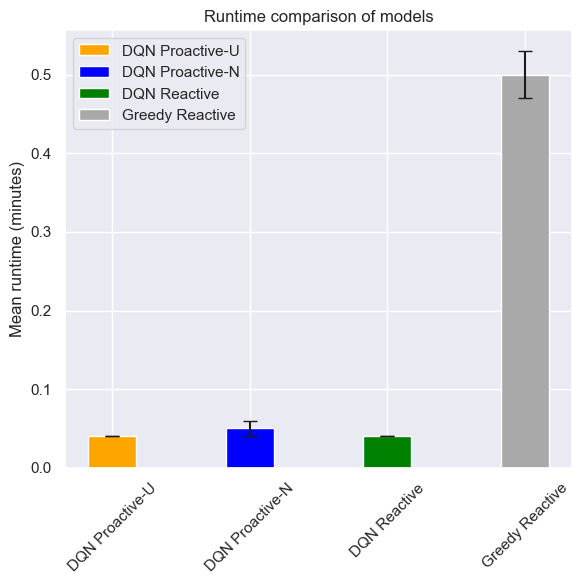

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}
# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
           yerr=comparison_table.loc[model, 'Std_Runtime'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean runtime (minutes)')
ax.set_title('Runtime comparison of models')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()



Linear Regression Results (using raw data):

Metric: Cancelled flights
  DQN Proactive-U: slope=-3.5947, p-value=0.150
  DQN Proactive-N: slope=0.5135, p-value=0.827
  DQN Reactive: slope=2.3586, p-value=0.333
  Greedy Reactive: slope=-2.6031, p-value=0.320

Metric: Delays (minutes)
  DQN Proactive-U: slope=-1161.9928, p-value=0.011
  DQN Proactive-N: slope=899.3720, p-value=0.041
  DQN Reactive: slope=0.0000, p-value=nan
  Greedy Reactive: slope=27.0336, p-value=0.762

Metric: Tail swaps
  DQN Proactive-U: slope=-2.5359, p-value=0.000
  DQN Proactive-N: slope=0.0424, p-value=0.959
  DQN Reactive: slope=0.0000, p-value=nan
  Greedy Reactive: slope=4.3073, p-value=0.072


ValueError: not enough values to unpack (expected 2, got 0)

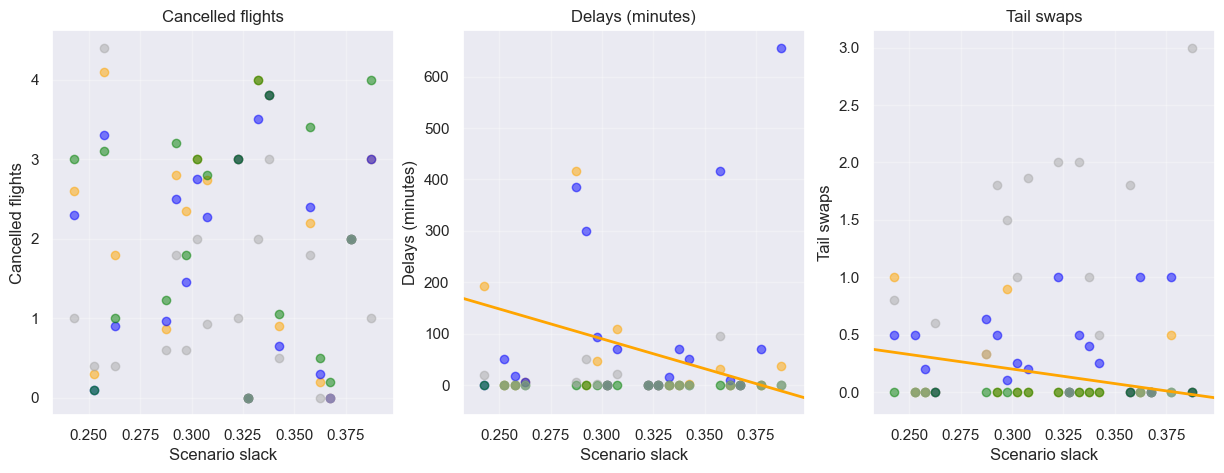

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Define a color map and human-readable labels for the models
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue',   'DQN Proactive-N'),
    'DQN Reactive':     ('green', 'DQN Reactive'),
    'Greedy Reactive':  ('darkgrey', 'Greedy Reactive')
}

# Define metrics
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays",          "Delays (minutes)"), 
    ("TailSwaps",            "Tail swaps")
]

# -------------------------
# 1) Create aggregated data for plotting points (just to reduce scatter clutter)
# Note: This bucketing is only used for the scatter plot visualization, not for the regression
# -------------------------
bucket_size = 0.005  # Bucket width for aggregated scatter points
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [
    f"{bucket_edges[i]:.3f}-{bucket_edges[i+1]:.3f}"
    for i in range(len(bucket_edges)-1)
]

merged_df['SlackInterval'] = pd.cut(
    merged_df['ScenarioSlack'],
    bins=bucket_edges,
    labels=bucket_labels,
    include_lowest=True,
    ordered=False
)

# Aggregate data by taking the mean of the numeric metrics
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False, observed=True)
    [[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval is NaN
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Function to get the midpoint from the SlackInterval label
def interval_midpoint(interval_label):
    start_str, end_str = interval_label.split('-')
    return 0.5 * (float(start_str) + float(end_str))

# Add a midpoint for plotting scatter
agg_df['SlackMidpoint'] = agg_df['SlackInterval'].apply(interval_midpoint)

# -------------------------
# 2) Prepare figure
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Note: Linear regression is performed on raw data points, not on bucketed data
print("\nLinear Regression Results (using raw data):")

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    print(f"\nMetric: {ylabel}")
    
    # We'll track the min and max slack for this subplot
    all_slacks_for_metric = []
    
    for desired_label in model_order:
        # Get the internal key (e.g., 'DQN Proactive-U') from the dict
        matching_models = [
            k for k, v in model_colors.items() if v[1] == desired_label
        ]
        if not matching_models:
            continue
        model_key = matching_models[0]
        color = model_colors[model_key][0]
        
        # -------------------------
        # A) Compute linear regression using raw data points (not bucketed)
        # -------------------------
        df_model = merged_df[merged_df['Model'] == model_key].copy()
        # Keep valid rows
        df_model = df_model.dropna(subset=['ScenarioSlack', metric])
        if len(df_model) < 2:
            continue
        
        # Raw x and y (using individual data points, not bucketed)
        X_raw = df_model['ScenarioSlack']
        y_raw = df_model[metric]
        
        # Keep track of these Slack values
        all_slacks_for_metric.extend(X_raw.tolist())
        
        # Add constant term for intercept
        X_raw = sm.add_constant(X_raw)
        
        # Fit OLS model
        model = sm.OLS(y_raw, X_raw).fit()
        slope = model.params.iloc[1]  # Use iloc instead of positional indexing
        intercept = model.params.iloc[0]
        p_value = model.pvalues.iloc[1]  # p-value for the slope coefficient
        
        print(f"  {desired_label}: slope={slope:.4f}, p-value={p_value:.3f}")
        
        # -------------------------
        # B) Plot bucketed points for scatter visualization only
        # -------------------------
        df_agg_model = agg_df[agg_df['Model'] == model_key]
        x_vals = df_agg_model['SlackMidpoint'].values
        y_vals = df_agg_model[metric].values
        
        ax.scatter(x_vals, y_vals, color=color, alpha=0.5)
    
    # After looping over all models, we know the min & max Slack for this metric
    if len(all_slacks_for_metric) > 0:
        min_slack = min(all_slacks_for_metric)
        max_slack = max(all_slacks_for_metric)
        
        # Add a small margin to avoid points being on the very edge
        margin = 0.01
        slack_left = max(0, min_slack - margin)
        slack_right = min(1, max_slack + margin)
        
        # Now, re-loop to plot the regression lines using the updated x-range
        for desired_label in model_order:
            matching_models = [
                k for k, v in model_colors.items() if v[1] == desired_label
            ]
            if not matching_models:
                continue
            model_key = matching_models[0]
            color = model_colors[model_key][0]
            
            # Raw data for regression (not bucketed)
            df_model = merged_df[merged_df['Model'] == model_key].copy()
            df_model = df_model.dropna(subset=['ScenarioSlack', metric])
            if len(df_model) < 2:
                continue
            
            X_raw = df_model['ScenarioSlack']
            y_raw = df_model[metric]
            X_raw = sm.add_constant(X_raw)
            model = sm.OLS(y_raw, X_raw).fit()
            
            # Only plot if slope is negative and p-value < 0.05
            if model.params.iloc[1] < 0 and model.pvalues.iloc[1] < 0.05:
                # Create a denser grid within [slack_left, slack_right]
                x_grid = np.linspace(slack_left, slack_right, 100)
                X_grid = sm.add_constant(x_grid)
                y_pred_line = model.predict(X_grid)
                
                # Plot the regression line
                ax.plot(x_grid, y_pred_line, color=color, linewidth=2, label=desired_label)
        
        # Finally, set the x-limits to the data range
        ax.set_xlim(slack_left, slack_right)
    
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, alpha=0.3)

# Create a global legend (need to deduplicate labels)
handles, labels = axes[0].get_legend_handles_labels()
unique_pairs = list(dict(zip(labels, handles)).items())
labels_unique, handles_unique = zip(*unique_pairs)

fig.legend(
    handles_unique, labels_unique,
    loc='center', bbox_to_anchor=(0.5, -0.05),
    ncol=4, title="Model", frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of schedule robustness (Raw data regression)", y=1.02)
plt.show()



Distribution of scenarios by number of disrupted flights:
Disrupted flights = 0: 235 rows (25.8%)
Disrupted flights = 1: 49 rows (5.4%)
Disrupted flights = 2: 242 rows (26.6%)
Disrupted flights = 3: 131 rows (14.4%)
Disrupted flights = 4: 227 rows (24.9%)
Disrupted flights = 5: 26 rows (2.9%)

Distribution of scenarios by number of disrupted flights (DQN Proactive-N only):
Disrupted flights = 0: 71 rows (27.3%)
Disrupted flights = 1: 12 rows (4.6%)
Disrupted flights = 2: 67 rows (25.8%)
Disrupted flights = 3: 37 rows (14.2%)
Disrupted flights = 4: 64 rows (24.6%)
Disrupted flights = 5: 9 rows (3.5%)

Scenarios with 0 disrupted flights but non-zero cancellations:

Scenarios with 0 disrupted flights but non-zero tail swaps:

Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 14 scenarios
Disrupted flights = 1: 6 scenarios
Disrupted flights = 2: 13 scenarios
Disrupted flights = 3: 7 scenarios
Disrupted flights = 4: 9 scenarios
Disrupted flights = 5: 3 scenari

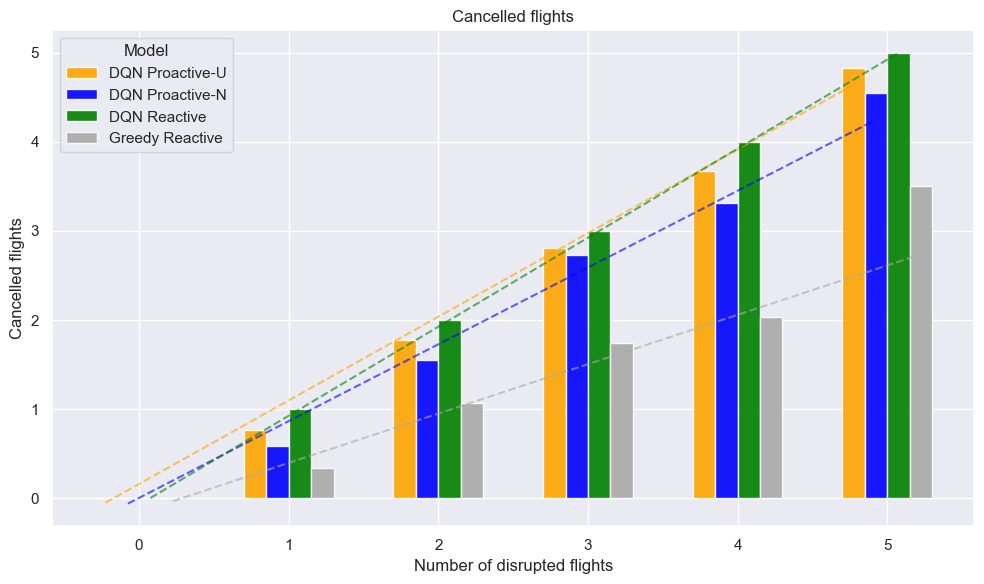


Slopes for Delays (minutes) (raw data regressions):
 DQN Proactive-U: slope=-29.20, intercept=139.60, p=0.0084, R²=0.027, n=260
 DQN Proactive-N: slope=19.55, intercept=83.60, p=0.0636, R²=0.013, n=260
 DQN Reactive: slope=0.00, intercept=0.00, p=nan, R²=nan, n=260
 Greedy Reactive: slope=3.07, intercept=3.11, p=0.1486, R²=0.016, n=130
 Average slope: -1.65 per disrupted flight


c:\Users\elisa\CursorMscThesis\msc-thesis-drl-adm\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


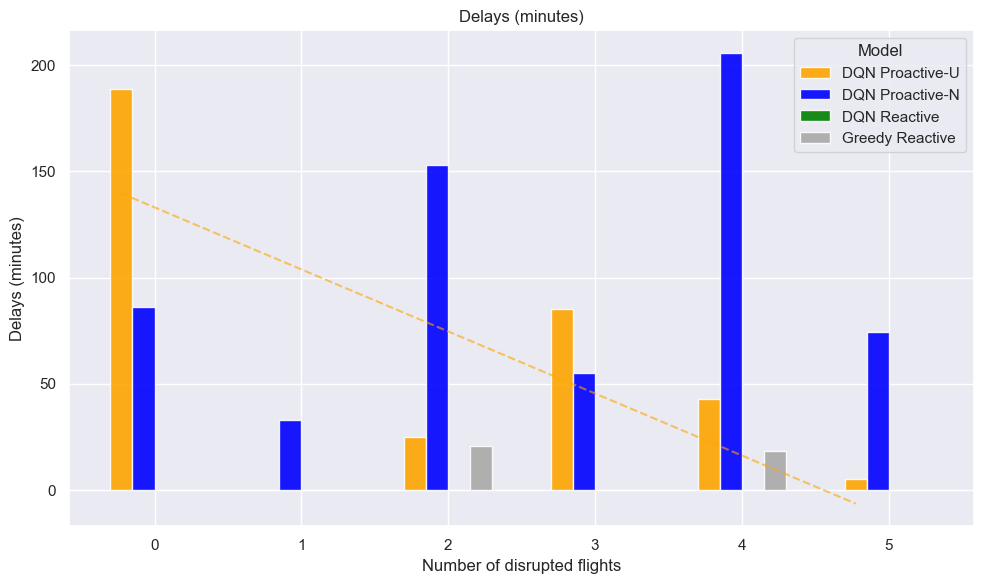


Slopes for Tail swaps (raw data regressions):
 DQN Proactive-U: slope=-0.01, intercept=0.20, p=0.3489, R²=0.003, n=260
 DQN Proactive-N: slope=0.00, intercept=0.35, p=0.8555, R²=0.000, n=260
 DQN Reactive: slope=0.00, intercept=0.00, p=nan, R²=nan, n=260
 Greedy Reactive: slope=0.45, intercept=0.04, p=0.0000, R²=0.468, n=130
 Average slope: 0.11 per disrupted flight


c:\Users\elisa\CursorMscThesis\msc-thesis-drl-adm\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


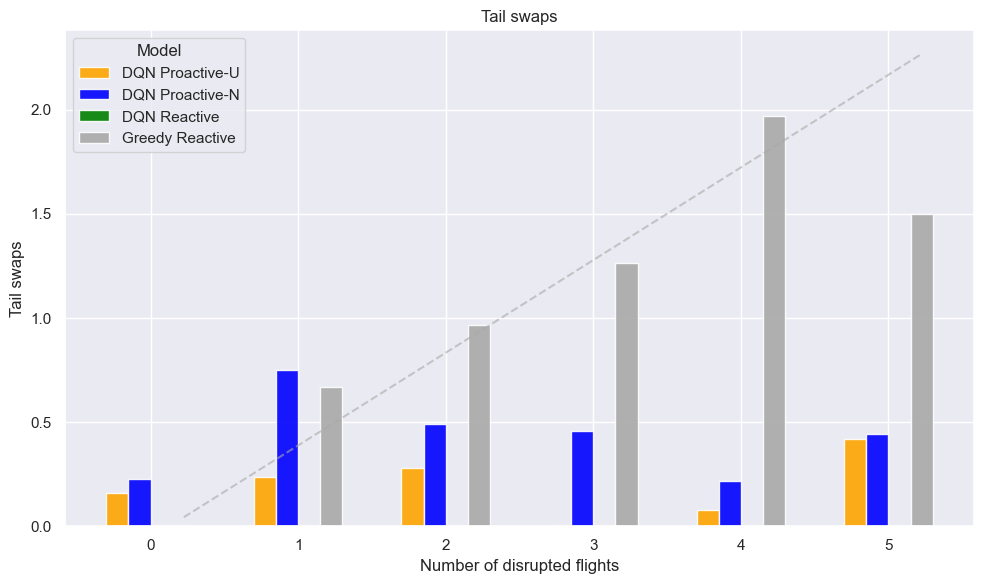

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm   # we'll use statsmodels for OLS
# or from scipy import stats   # either is fine

# Print distribution of scenarios across number of disrupted flights
print("\nDistribution of scenarios by number of disrupted flights:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].count()
for n_disrupted, count in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {count} rows ({count/len(merged_df)*100:.1f}%)")

# Print distribution of scenarios across number of disrupted flights for DQN Proactive-N
print("\nDistribution of scenarios by number of disrupted flights (DQN Proactive-N only):")
proactive_n_df = merged_df[merged_df['Model'] == 'DQN Proactive-N']
scenario_counts = proactive_n_df.groupby('ActualDisruptedFlights')['Scenario'].count()
for n_disrupted, count in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {count} rows ({count/len(proactive_n_df)*100:.1f}%)")

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"), 
    ("TailSwaps", "Tail swaps")
]

# ------------------------------------------------------------------
# 0) Just some diagnostic prints (as in your original code)
# ------------------------------------------------------------------
print("\nScenarios with 0 disrupted flights but non-zero cancellations:")
for model in ['DQN Reactive', 'Greedy Reactive']:
    scenarios = merged_df[
        (merged_df['Model'] == model) & 
        (merged_df['ActualDisruptedFlights'] == 0) & 
        (merged_df['TotalCancelledFlights'] > 0)
    ]['Scenario'].unique()
    if len(scenarios) > 0:
        print(f"\n{model}:")
        for scenario in scenarios:
            print(f"Scenario: {scenario}")

print("\nScenarios with 0 disrupted flights but non-zero tail swaps:")
for model in ['DQN Reactive', 'Greedy Reactive']:
    scenarios = merged_df[
        (merged_df['Model'] == model) & 
        (merged_df['ActualDisruptedFlights'] == 0) & 
        (merged_df['TailSwaps'] > 0)
    ]['Scenario'].unique()
    if len(scenarios) > 0:
        print(f"\n{model}:")
        for scenario in scenarios:
            print(f"Scenario: {scenario}")

print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# ------------------------------------------------------------------
# 1) Aggregate data by (Model, ActualDisruptedFlights) for bar chart
# ------------------------------------------------------------------
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# ------------------------------------------------------------------
# 2) Function to compute slope/intercept using *raw data*
#    for one model & one metric
# ------------------------------------------------------------------
def get_raw_regression_params(df, model_name, metric):
    """
    Returns (slope, intercept, n_points, p_value, r_squared)
    from a linear regression of metric ~ ActualDisruptedFlights (raw).
    """
    # Filter raw rows for that model
    df_model = df[(df['Model'] == model_name)].copy()
    df_model = df_model.dropna(subset=['ActualDisruptedFlights', metric])
    if len(df_model) < 2:
        return None, None, 0, None, None
    
    x_raw = df_model['ActualDisruptedFlights'].values
    y_raw = df_model[metric].values
    
    # Fit OLS
    import statsmodels.api as sm
    X_ols = sm.add_constant(x_raw)  # shape (n, 2) => columns: [const, x_raw]
    ols_model = sm.OLS(y_raw, X_ols).fit()
    
    # Option A) by position
    intercept = ols_model.params[0]  # 'const'
    slope     = ols_model.params[1]  # the next column
    
    # Optionally, get p-value and R^2
    p_value = ols_model.pvalues[1]    # for slope
    r_sq    = ols_model.rsquared
    n_points = len(df_model)
    
    return slope, intercept, n_points, p_value, r_sq


# ------------------------------------------------------------------
# 3) Create bar chart + plot raw-data regression lines
# ------------------------------------------------------------------
for metric, ylabel in metrics:
    plt.figure(figsize=(10, 6))
    
    # We'll get a sorted list of unique disrupted-flight counts
    # for the final x-axis.
    all_disrupted = sorted(agg_df['ActualDisruptedFlights'].unique())
    
    # Calculate number of models and adjust bar width and spacing
    n_models = len(model_colors)
    bar_width = 0.15
    total_width = bar_width * n_models
    start_offset = -total_width / 2 + bar_width / 2  # to center groups of bars
    
    print(f"\nSlopes for {ylabel} (raw data regressions):")
    slopes = []
    
    bar_offset = start_offset
    for model_name, (color, label) in model_colors.items():
        # Get aggregated y-values for bar chart
        model_data_agg = agg_df[agg_df['Model'] == model_name].copy()
        model_data_agg = model_data_agg.sort_values(by='ActualDisruptedFlights')
        
        x_bar = model_data_agg['ActualDisruptedFlights'].values
        y_bar = model_data_agg[metric].values
        
        # Plot the bars
        plt.bar(
            x_bar + bar_offset,
            y_bar,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.9
        )
        
        # ------------------------------
        # 3A) Get slope & intercept from RAW data
        # ------------------------------
        slope, intercept, n_points, p_val, r_sq = get_raw_regression_params(merged_df, model_name, metric)
        if slope is not None:
            # We'll store slope just for printing an "average slope"
            slopes.append(slope)
            
            # Only plot regression line if p < 0.05
            if p_val < 0.05:
                # Create a line from min(x_bar) to max(x_bar), or from the entire set
                x_line = np.array([min(all_disrupted), max(all_disrupted)])
                # Predicted y
                y_line = intercept + slope * x_line
                
                # Plot the regression line slightly offset so it goes above the bars
                plt.plot(x_line + bar_offset, y_line, '--', color=color, alpha=0.6)
            
            print(f" {label}: slope={slope:.2f}, intercept={intercept:.2f}, "
                  f"p={p_val:.4f}, R²={r_sq:.3f}, n={n_points}")
        else:
            print(f" {label}: Not enough data to do regression.")
        
        bar_offset += bar_width
    
    if len(slopes) > 0:
        print(f" Average slope: {np.mean(slopes):.2f} per disrupted flight")

    # ------------------------------
    # 3B) Final labeling
    # ------------------------------
    plt.xlabel("Number of disrupted flights")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.grid(True, axis='y')
    plt.legend(title="Model", frameon=True)
    plt.tight_layout()
    plt.show()
